# Implementación en Pyomo

In [ ]:

import pandas as pd
import pyomo.environ as pyo
from pyomo.opt import SolverFactory
import math
import time
print("--- 1. CARGANDO Y PREPARANDO DATOS ---")

# Cargar datos (Asegúrate de que los archivos estén en la ruta correcta)
try:
    clients = pd.read_csv('clients.csv')
    depots = pd.read_csv('depots.csv')
    vehicles = pd.read_csv('vehicles.csv')
    params = pd.read_csv('parameters_urban.csv').set_index('Parameter')['Value'].to_dict()
    
    # Filtrar para prueba rápida (Opcional: comenta esto para correr con los 90 clientes)
    # clients = clients.head(15)  # RECOMENDACIÓN: Prueba primero con 15 clientes
    
    print(f"Datos cargados: {len(clients)} Clientes, {len(depots)} Depósitos, {len(vehicles)} Vehículos")
except Exception as e:
    print(f"Error cargando datos: {e}")

# Configuración de parámetros
AVERAGE_SPEED_KMH = 25.0
C_FIXED = params.get('C_fixed', 50000)
# Costos unificados aproximados para la función objetivo
C_DIST = params.get('C_dist', 2500)
C_TIME = params.get('C_time', 7600)
FUEL_PRICE = params.get('fuel_price', 16300)

# Función de distancia
def get_dist(lat1, lon1, lat2, lon2):
    R = 6371
    phi1, phi2 = math.radians(lat1), math.radians(lat2)
    dphi = math.radians(lat2 - lat1)
    dlambda = math.radians(lon2 - lon1)
    a = math.sin(dphi/2)**2 + math.cos(phi1)*math.cos(phi2)*math.sin(dlambda/2)**2
    return R * 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))

# Crear matriz de distancias y diccionario de nodos
all_nodes = pd.concat([
    clients[['StandardizedID', 'Latitude', 'Longitude']].assign(Type='Client'),
    depots[['StandardizedID', 'Latitude', 'Longitude']].assign(Type='Depot')
], ignore_index=True)

dist_matrix = {}
for i, r1 in all_nodes.iterrows():
    for j, r2 in all_nodes.iterrows():
        id1, id2 = r1['StandardizedID'], r2['StandardizedID']
        dist_matrix[(id1, id2)] = get_dist(r1['Latitude'], r1['Longitude'], r2['Latitude'], r2['Longitude'])

print("\n--- 2. CONSTRUYENDO MODELO PYOMO (MD-VRP) ---")

model = pyo.ConcreteModel()

# CONJUNTOS
model.C = pyo.Set(initialize=clients['StandardizedID'].tolist()) # Clientes
model.H = pyo.Set(initialize=depots['StandardizedID'].tolist())  # Depósitos
model.V = pyo.Set(initialize=vehicles['StandardizedID'].tolist()) # Vehículos
model.N = model.C | model.H # Todos los nodos (Clientes + Depósitos)

# Demanda
demanda = {row['StandardizedID']: row['Demand'] for _, row in clients.iterrows()}
# Capacidad Vehículos
cap_vehiculo = {row['StandardizedID']: row['Capacity'] for _, row in vehicles.iterrows()}
# Capacidad Depósitos
cap_deposito = {row['StandardizedID']: row['Capacity'] for _, row in depots.iterrows()}

# x[i,j,v] = 1 si el vehículo v va de i a j
model.x = pyo.Var(model.N, model.N, model.V, domain=pyo.Binary)
# u[i] = Variable auxiliar para eliminación de subtours (MTZ) y carga acumulada
model.u = pyo.Var(model.C, domain=pyo.NonNegativeReals)

# Minimizar Costos
# Costo aprox por km considerando distancia + tiempo + combustible promedio
cost_per_km = C_DIST + (C_TIME / AVERAGE_SPEED_KMH) + (FUEL_PRICE / 30.0) 

def obj_rule(m):
    # Costo de transporte
    transport_cost = sum(dist_matrix[i,j] * cost_per_km * m.x[i,j,v] 
                         for i in m.N for j in m.N for v in m.V if i != j)
    # Costo fijo (se activa si el vehículo sale de algún depósito)
    fixed_cost = sum(C_FIXED * m.x[h,j,v] 
                     for h in m.H for j in m.C for v in m.V)
    return transport_cost + fixed_cost

model.obj = pyo.Objective(rule=obj_rule, sense=pyo.minimize)

# RESTRICCIONES

# 1. Visitar cada cliente exactamente una vez
def visit_once(m, c):
    return sum(m.x[i, c, v] for v in m.V for i in m.N if i != c) == 1
model.r_visit = pyo.Constraint(model.C, rule=visit_once)

# 2. Conservación de flujo (Si entra a un cliente, debe salir)
def flow_conserv(m, c, v):
    return sum(m.x[i, c, v] for i in m.N if i != c) == \
           sum(m.x[c, j, v] for j in m.N if j != c)
model.r_flow = pyo.Constraint(model.C, model.V, rule=flow_conserv)

# 3. Cada vehículo sale de A LO SUMO un depósito (y debe regresar al mismo)
def start_depot(m, v):
    return sum(m.x[h, j, v] for h in m.H for j in m.C) <= 1
model.r_start = pyo.Constraint(model.V, rule=start_depot)

def end_depot(m, v):
    # Debe entrar al mismo depósito del que salió
    return sum(m.x[h, j, v] for h in m.H for j in m.C) == \
           sum(m.x[j, h, v] for h in m.H for j in m.C)
model.r_end = pyo.Constraint(model.V, rule=end_depot)

# 4. Capacidad del Vehículo y Eliminación de Subtours (MTZ)
def capacity_mtz(m, i, j, v):
    if i in m.H or i == j: return pyo.Constraint.Skip
    # Si x[i,j,v]=1 => u[j] >= u[i] + demanda[j]
    return m.u[j] >= m.u[i] + demanda[j] - (10000) * (1 - m.x[i,j,v])
model.r_cap = pyo.Constraint(model.C, model.C, model.V, rule=capacity_mtz)

# Límites de variable u (carga acumulada)
def cap_limits(m, i):
    return m.u[i] <= sum(cap_vehiculo[v] * sum(m.x[i,j,v] for j in m.N) for v in m.V)

model.r_u_limit = pyo.Constraint(model.C, rule=cap_limits)

print("Modelo construido. Iniciando Solver...")


# SOLVER con HIGHS
solver = SolverFactory('appsi_highs') 
solver.options['time_limit'] = 600

print("Resolviendo con HIGHS local...")
results = solver.solve(model, tee=True)

print("\n--- 4. PROCESANDO RESULTADOS ---")

final_solution = []

# Extraer rutas de las variables x[i,j,v]
for v in model.V:
    # Verificar si el vehículo fue usado
    is_used = False
    start_node = None
    
    # Buscar arco de salida del depósito
    for h in model.H:
        for j in model.C:
            if pyo.value(model.x[h, j, v]) > 0.5:
                is_used = True
                start_node = h
                next_node = j
                break
        if is_used: break
    
    if is_used:
        route = [start_node, next_node]
        demands = [demanda[next_node]]
        current_load = demanda[next_node]
        dist = dist_matrix[start_node, next_node]
        
        # Seguir la ruta hasta volver al depósito
        curr = next_node
        while curr not in model.H:
            found_next = False
            for j in model.N:
                if j != curr and pyo.value(model.x[curr, j, v]) > 0.5:
                    dist += dist_matrix[curr, j]
                    route.append(j)
                    if j in model.C:
                        demands.append(demanda[j])
                        current_load += demanda[j]
                    curr = j
                    found_next = True
                    break
            if not found_next: break # Seguridad
            
        # Guardar datos formateados para el CSV
        final_solution.append({
            'VehicleId': v,
            'DepotId': start_node,
            'InitialLoad': current_load,
            'RouteSequence': route,
            'ClientsServed': len(route) - 2, # Menos depots inicio/fin
            'DemandsSatisfied': demands,
            'TotalDistance': dist,
            'TotalTime': (dist / AVERAGE_SPEED_KMH) * 60,
            'FuelCost': (dist / 30.0) * FUEL_PRICE # Eficiencia aprox 30 km/gal
        })

# csv de verificación
output_rows = []
for r in final_solution:
    output_rows.append({
        'VehicleId': r['VehicleId'],
        'DepotId': r['DepotId'],
        'InitialLoad': r['InitialLoad'],
        'RouteSequence': "-".join(r['RouteSequence']),
        'ClientsServed': r['ClientsServed'],
        'DemandsSatisfied': "-".join(map(str, r['DemandsSatisfied'])),
        'TotalDistance': round(r['TotalDistance'], 2),
        'TotalTime': round(r['TotalTime'], 1),
        'FuelCost': round(r['FuelCost'], 2)
    })

if output_rows:
    df_result = pd.DataFrame(output_rows)
    df_result.to_csv('results/verificacion_caso3.csv', index=False)
    print(f"Solución Pyomo generada con {len(df_result)} vehículos.")
    print("Archivo guardado: results/verificacion_caso3.csv")
else:
    print("El solver no encontró solución factible en el tiempo límite.")

--- 1. CARGANDO Y PREPARANDO DATOS ---
Datos cargados: 90 Clientes, 12 Depósitos, 45 Vehículos

--- 2. CONSTRUYENDO MODELO PYOMO (MD-VRP) ---
Modelo construido. Iniciando Solver...
Resolviendo con HIGHS local...
Running HiGHS 1.12.0 (git hash: n/a): Copyright (c) 2025 HiGHS under MIT licence terms
MIP has 364770 rows; 467730 cols; 2867490 nonzeros; 467640 integer variables (467640 binary)
Coefficient ranges:
  Matrix  [1e+00, 1e+04]
  Cost    [2e+02, 2e+05]
  Bound   [1e+00, 1e+00]
  RHS     [1e+00, 1e+04]
Presolving model
364770 rows, 457740 cols, 2863440 nonzeros  2s
364770 rows, 413190 cols, 2685240 nonzeros  168s
Presolve reductions: rows 364770(-0); columns 413190(-54540); nonzeros 2685240(-182250) 

Solving MIP model with:
   364770 rows
   413190 cols (413100 binary, 0 integer, 0 implied int., 90 continuous, 0 domain fixed)
   2685240 nonzeros

Src: B => Branching; C => Central rounding; F => Feasibility pump; H => Heuristic;
     I => Shifting; J => Feasibility jump; L => Sub-M

# Implementación algoritmo Greedy (unicamente para comparaciones y para un resultado rapido)

In [ ]:
import pandas as pd
import math
import time

print("INICIANDO PROCESO")

# Cargar Datos
try:
    clients = pd.read_csv('clients.csv')
    depots = pd.read_csv('depots.csv')
    vehicles = pd.read_csv('vehicles.csv')
    params = pd.read_csv('parameters_urban.csv').set_index('Parameter')['Value'].to_dict()
    print("Datos cargados correctamente.")
    print(f"   - Clientes: {len(clients)}")
    print(f"   - Depósitos: {len(depots)}")
    print(f"   - Vehículos: {len(vehicles)}")
except Exception as e:
    print(f"Error cargando datos: {e}")
    raise

AVERAGE_SPEED_KMH = 25.0
FUEL_PRICE = params.get('fuel_price', 16300) # Valor por defecto si falla la lectura
C_FIXED = params.get('C_fixed', 50000)

fuel_eff = {'small van': 40.0, 'medium van': 30.0, 'light truck': 25.0}

def get_dist(row1, row2):
    # Distancia Haversine simple
    try:
        R = 6371
        lat1, lon1 = float(row1['Latitude']), float(row1['Longitude'])
        lat2, lon2 = float(row2['Latitude']), float(row2['Longitude'])
        phi1, phi2 = math.radians(lat1), math.radians(lat2)
        dphi = math.radians(lat2 - lat1)
        dlambda = math.radians(lon2 - lon1)
        a = math.sin(dphi/2)**2 + math.cos(phi1)*math.cos(phi2)*math.sin(dlambda/2)**2
        return R * 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    except:
        return 10000.0

# Algoritmo
available_vehicles = vehicles.to_dict('records')
unserved_clients = clients.to_dict('records')
depot_capacity = {d['StandardizedID']: d['Capacity'] for _, d in depots.iterrows()}
final_solution = []

print("\nCOMENZANDO ASIGNACIÓN DE RUTAS")
start_time = time.time()

for i, veh in enumerate(available_vehicles):
    # Si ya no hay clientes, parar
    if not unserved_clients: 
        print("Todos los clientes han sido atendidos")
        break
    
    if i % 5 == 0: 
        print(f"Procesando vehículo {i+1}/{len(available_vehicles)} (Clientes restantes: {len(unserved_clients)})...")
    
    best_route = None
    v_cap = float(veh['Capacity'])
    v_range = float(veh['Range']) 
    v_eff = fuel_eff.get(veh['VehicleType'], 25.0)
    
    # Probar desde cada depósito
    for _, depot in depots.iterrows():
        d_id = depot['StandardizedID']
        if depot_capacity[d_id] <= 0: continue
        
        # Construccion de ruta
        route = []
        load = 0.0
        dist = 0.0
        curr_loc = depot
        local_unserved = unserved_clients.copy()
        
        safety_counter = 0
        while safety_counter < 50:
            safety_counter += 1
            nearest = None
            min_d = float('inf')
            
            for client in local_unserved:
                d = get_dist(curr_loc, client)
                dist_home = get_dist(client, depot)
                
                # Restricciones
                if (load + client['Demand'] <= v_cap and 
                    load + client['Demand'] <= depot_capacity[d_id] and
                    dist + d + dist_home <= v_range):
                    
                    if d < min_d:
                        min_d = d
                        nearest = client
            
            if nearest:
                route.append(nearest)
                load += nearest['Demand']
                dist += min_d
                curr_loc = nearest
                local_unserved.remove(nearest)
            else:
                break
        
        # Evaluar si esta ruta es la mejor para este vehículo
        if route:
            # Priorizamos la ruta que lleve mas carga
            if best_route is None or load > best_route['load']:
                return_dist = get_dist(curr_loc, depot)
                total_dist = dist + return_dist
                best_route = {
                    'VehicleId': veh['StandardizedID'],
                    'DepotId': d_id,
                    'InitialLoad': load,
                    'RouteSequence': [d_id] + [c['StandardizedID'] for c in route] + [d_id],
                    'ClientsServed': len(route),
                    'DemandsSatisfied': [c['Demand'] for c in route],
                    'TotalDistance': total_dist,
                    'TotalTime': (total_dist / AVERAGE_SPEED_KMH) * 60,
                    'FuelCost': (total_dist / v_eff) * FUEL_PRICE,
                    'RawClients': route,
                    'load': load
                }

    # Asignar la mejor ruta encontrada
    if best_route:
        final_solution.append(best_route)
        depot_capacity[best_route['DepotId']] -= best_route['InitialLoad']
        # Eliminar clientes reales de la lista global
        ids_served = {c['StandardizedID'] for c in best_route['RawClients']} # Usar set para velocidad
        unserved_clients = [c for c in unserved_clients if c['StandardizedID'] not in ids_served]

print(f"\n--- FIN DEL PROCESO ---")
print(f"Tiempo total: {time.time() - start_time:.2f} segundos")

# Generar CSV
output_rows = []
for r in final_solution:
    output_rows.append({
        'VehicleId': r['VehicleId'],
        'DepotId': r['DepotId'],
        'InitialLoad': r['InitialLoad'],
        'RouteSequence': "-".join(r['RouteSequence']),
        'ClientsServed': r['ClientsServed'],
        'DemandsSatisfied': "-".join(map(str, r['DemandsSatisfied'])),
        'TotalDistance': round(r['TotalDistance'], 2),
        'TotalTime': round(r['TotalTime'], 1),
        'FuelCost': round(r['FuelCost'], 2)
    })

if output_rows:
    df_result = pd.DataFrame(output_rows)
    df_result.to_csv('results/verificacion_caso3.csv', index=False)
    print("Archivo 'verificacion_caso3.csv' generado")
    print(f"Clientes atendidos: {len(clients) - len(unserved_clients)}/{len(clients)}")
else:
    print("No se generaron rutas")

--- INICIANDO PROCESO ---
✅ Datos cargados correctamente.
   - Clientes: 90
   - Depósitos: 12
   - Vehículos: 45

--- COMENZANDO ASIGNACIÓN DE RUTAS ---
Procesando vehículo 1/45 (Clientes restantes: 90)...
Procesando vehículo 6/45 (Clientes restantes: 38)...
¡Todos los clientes han sido atendidos!

--- FIN DEL PROCESO ---
Tiempo total: 0.43 segundos
✅ Archivo 'verificacion_caso3.csv' generado exitosamente.
Clientes atendidos: 90/90


In [ ]:
import pandas as pd

# 1. Cargar el archivo de resultados
df_resultados = pd.read_csv('results/verificacion_caso3.csv')
params = pd.read_csv('parameters_urban.csv').set_index('Parameter')['Value'].to_dict()

# 2. Extraer datos de costo
C_FIXED = params.get('C_fixed', 50000)  # Costo fijo por vehículo
C_DIST = params.get('C_dist', 2500)     # Costo por km
C_TIME = params.get('C_time', 7600)     # Costo por hora

# 3. Calcular Costo Total
costo_total_operacion = 0

print("--- DESGLOSE DE COSTOS ---")
for index, row in df_resultados.iterrows():
    # Costos individuales
    c_fijo = C_FIXED
    c_distancia = row['TotalDistance'] * C_DIST
    c_tiempo = (row['TotalTime'] / 60) * C_TIME  # Convertir minutos a horas
    c_combustible = row['FuelCost']
    
    # Suma por vehículo
    costo_vehiculo = c_fijo + c_distancia + c_tiempo + c_combustible
    costo_total_operacion += costo_vehiculo
    

print(f"\n💰 COSTO TOTAL DE LA OPERACIÓN (Z): ${costo_total_operacion:,.2f} COP")
print(f"---------------------------------------")
print(f"Resumen:")
print(f"- Vehículos usados: {len(df_resultados)}")
print(f"- Distancia total: {df_resultados['TotalDistance'].sum():.1f} km")
print(f"- Costo promedio por entrega: ${costo_total_operacion / 90:,.0f} COP")

--- DESGLOSE DE COSTOS ---

💰 COSTO TOTAL DE LA OPERACIÓN (Z): $1,573,377.62 COP
---------------------------------------
Resumen:
- Vehículos usados: 10
- Distancia total: 318.0 km
- Costo promedio por entrega: $17,482 COP


# Implementacion hibrida inyectando valores desde la solucion Greedy a Pyomo

In [ ]:
import pandas as pd
import pyomo.environ as pyo
from pyomo.opt import SolverFactory
import math
import time

print("ESTRATEGIA OPTIMIZADA")

# 1. CARGA DE DATOS
try:
    clients = pd.read_csv('clients.csv')
    depots = pd.read_csv('depots.csv')
    vehicles = pd.read_csv('vehicles.csv')
    try:
        params = pd.read_csv('parameters_urban.csv').set_index('Parameter')['Value'].to_dict()
    except:
        params = {}
    print(f"Datos cargados: {len(clients)} Clientes, {len(depots)} Depósitos, {len(vehicles)} Vehículos")
except Exception as e:
    print(f"Error cargando datos: {e}")
    raise

# Parámetros
AVERAGE_SPEED_KMH = 25.0
C_FIXED = float(params.get('C_fixed', 50000))
C_DIST = float(params.get('C_dist', 2500))
C_TIME = float(params.get('C_time', 7600))
FUEL_PRICE = float(params.get('fuel_price', 16300))

def get_dist(lat1, lon1, lat2, lon2):
    R = 6371
    phi1, phi2 = math.radians(lat1), math.radians(lat2)
    dphi = math.radians(lat2 - lat1)
    dlambda = math.radians(lon2 - lon1)
    a = math.sin(dphi/2)**2 + math.cos(phi1)*math.cos(phi2)*math.sin(dlambda/2)**2
    return R * 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))

# Solucion inicial
print("\nGenerando solución inicial")
start_heur = time.time()

# Estructuras
available_vehicles = vehicles.to_dict('records')
unserved_clients = clients.to_dict('records')
depot_caps = depots.set_index('StandardizedID')['Capacity'].to_dict()
depot_locs = depots.to_dict('records')
initial_solution = [] # Aquí guardaremos las rutas para inyectar a Pyomo

# Algoritmo Greedy
for veh in available_vehicles:
    if not unserved_clients: break
    best_route = None
    v_cap = float(veh['Capacity'])
    
    for depot in depot_locs:
        d_id = depot['StandardizedID']
        if depot_caps[d_id] <= 0: continue
        
        # Construir ruta
        route = []
        load = 0
        curr_lat, curr_lon = float(depot['Latitude']), float(depot['Longitude'])
        local_unserved = unserved_clients.copy()
        dist_acc = 0
        
        while True:
            nearest = None
            min_d = float('inf')
            for c in local_unserved:
                d = get_dist(curr_lat, curr_lon, float(c['Latitude']), float(c['Longitude']))
                d_home = get_dist(float(c['Latitude']), float(c['Longitude']), float(depot['Latitude']), float(depot['Longitude']))
                if load + c['Demand'] <= v_cap and depot_caps[d_id] >= load + c['Demand'] and dist_acc + d + d_home <= float(veh['Range']):
                    if d < min_d:
                        min_d = d
                        nearest = c
            
            if nearest:
                route.append(nearest)
                load += nearest['Demand']
                dist_acc += min_d
                curr_lat, curr_lon = float(nearest['Latitude']), float(nearest['Longitude'])
                local_unserved.remove(nearest)
            else:
                break
        
        if route:
            # Calcular costo simple para elegir mejor depot
            if best_route is None or len(route) > len(best_route['clients']):
                best_route = {'DepotId': d_id, 'clients': route, 'load': load}

    if best_route:
        # Guardar estructura para Pyomo
        r_clients = best_route['clients']
        route_nodes = [best_route['DepotId']] + [c['StandardizedID'] for c in r_clients] + [best_route['DepotId']]
        initial_solution.append({
            'VehicleId': veh['StandardizedID'],
            'RouteNodes': route_nodes,
            'Clients': r_clients,
            'Load': best_route['load']
        })
        # Actualizar globales
        depot_caps[best_route['DepotId']] -= best_route['load']
        ids = {c['StandardizedID'] for c in r_clients}
        unserved_clients = [c for c in unserved_clients if c['StandardizedID'] not in ids]

print(f"Solución inicial encontrada en {time.time()-start_heur:.2f}s. Clientes atendidos: {len(clients)-len(unserved_clients)}")

# Pyomo
print("\nConstruyendo modelo Pyomo e inyectando solución")

model = pyo.ConcreteModel()
model.C = pyo.Set(initialize=clients['StandardizedID'].tolist())
model.H = pyo.Set(initialize=depots['StandardizedID'].tolist())
model.V = pyo.Set(initialize=vehicles['StandardizedID'].tolist())
model.N = model.C | model.H

# Diccionarios y Params
locs = pd.concat([clients, depots]).set_index('StandardizedID')[['Latitude', 'Longitude']].to_dict('index')
dist_m = {(i,j): get_dist(locs[i]['Latitude'], locs[i]['Longitude'], locs[j]['Latitude'], locs[j]['Longitude']) for i in model.N for j in model.N}
dem = clients.set_index('StandardizedID')['Demand'].to_dict()
cap_v = vehicles.set_index('StandardizedID')['Capacity'].to_dict()

# Variables
model.x = pyo.Var(model.N, model.N, model.V, domain=pyo.Binary, initialize=0) # Importante initialize=0
model.u = pyo.Var(model.C, domain=pyo.NonNegativeReals, initialize=0)

print("Inyectando valores iniciales a las variables")
for route in initial_solution:
    v_id = route['VehicleId']
    nodes = route['RouteNodes']
    accum_load = 0
    
    # Marcar arcos usados en model.x
    for k in range(len(nodes)-1):
        i, j = nodes[k], nodes[k+1]
        if i in model.N and j in model.N: # Validación simple
            model.x[i, j, v_id].set_value(1)
            
            # Establecer carga acumulada en model.u
            if j in model.C:
                accum_load += dem[j]
                model.u[j].set_value(accum_load)

# Función Objetivo y Restricciones
cost_km = C_DIST + (C_TIME/AVERAGE_SPEED_KMH) + (FUEL_PRICE/30.0)
model.obj = pyo.Objective(expr=sum(dist_m[i,j]*cost_km*model.x[i,j,v] for i in model.N for j in model.N for v in model.V if i!=j) + 
                               sum(C_FIXED * model.x[h,j,v] for h in model.H for j in model.C for v in model.V), sense=pyo.minimize)

# Restricciones (Simplificadas para asegurar factibilidad del warm start)
def visit(m, c): return sum(m.x[i,c,v] for v in m.V for i in m.N if i!=c) == 1
model.r1 = pyo.Constraint(model.C, rule=visit)

def flow(m, c, v): return sum(m.x[i,c,v] for i in m.N if i!=c) == sum(m.x[c,j,v] for j in m.N if j!=c)
model.r2 = pyo.Constraint(model.C, model.V, rule=flow)

def start(m, v): return sum(m.x[h,j,v] for h in m.H for j in m.C) <= 1
model.r3 = pyo.Constraint(model.V, rule=start)

# MTZ relajada (M grande ajustada)
def cap_r(m, i, j, v):
    if i in m.H or i==j: return pyo.Constraint.Skip
    return m.u[j] >= m.u[i] + dem[j] - 10000*(1-model.x[i,j,v])
model.r4 = pyo.Constraint(model.C, model.C, model.V, rule=cap_r)

# Solver
print("\n--- PASO 3: Optimizando con HiGHS (Mejorando solución inicial)... ---")
solver = SolverFactory('appsi_highs')
solver.options['time_limit'] = 1500 
solver.options['mip_rel_gap'] = 0.05 # Parar si llega al 5% del óptimo


try:
    results = solver.solve(model, tee=True, warmstart=True) 
    print("Optimización finalizada.")
except Exception as e:
    print(f"Error en solve: {e}")


# CSV Final
final_output = []
for v in model.V:
    is_used = False
    start_node = None
    # Detectar uso revisando arcos desde depots
    for h in model.H:
        for j in model.C:
            if pyo.value(model.x[h,j,v]) > 0.5:
                is_used = True; start_node = h; next_node = j; break
        if is_used: break
    
    if is_used:
        # Reconstruir ruta
        route_nodes = [start_node, next_node]
        dems = [dem[next_node]]
        dist = dist_m[start_node, next_node]
        curr = next_node
        while curr not in model.H:
            found = False
            for j in model.N:
                if j!=curr and pyo.value(model.x[curr,j,v]) > 0.5:
                    dist += dist_m[curr,j]
                    route_nodes.append(j)
                    if j in model.C: dems.append(dem[j])
                    curr = j; found = True; break
            if not found: break
        
        final_output.append({
            'VehicleId': v, 'DepotId': start_node,
            'InitialLoad': sum(dems),
            'RouteSequence': "-".join(route_nodes),
            'ClientsServed': len(dems),
            'DemandsSatisfied': "-".join(map(str, dems)),
            'TotalDistance': dist,
            'TotalTime': (dist/AVERAGE_SPEED_KMH)*60,
            'FuelCost': (dist/30.0)*FUEL_PRICE
        })

df = pd.DataFrame(final_output)
df.to_csv('verificacion_caso3.csv', index=False)

# Métrica final
z_total = df['FuelCost'].sum() + (len(df)*C_FIXED) + (df['TotalTime'].sum()/60*C_TIME) + (df['TotalDistance'].sum()*C_DIST)
print(f"\nCOSTO FINAL (Z): ${z_total:,.0f} COP")
print(f"Archivo generado: verificacion_caso3.csv")

ESTRATEGIA OPTIMIZADA
Datos cargados: 90 Clientes, 12 Depósitos, 45 Vehículos

Generando solución inicial
Solución inicial encontrada en 0.17s. Clientes atendidos: 90

Construyendo modelo Pyomo e inyectando solución
Inyectando valores iniciales a las variables

--- PASO 3: Optimizando con HiGHS (Mejorando solución inicial)... ---
Running HiGHS 1.12.0 (git hash: n/a): Copyright (c) 2025 HiGHS under MIT licence terms
MIP has 364635 rows; 463680 cols; 2357100 nonzeros; 463590 integer variables (463590 binary)
Coefficient ranges:
  Matrix  [1e+00, 1e+04]
  Cost    [2e+02, 2e+05]
  Bound   [1e+00, 1e+00]
  RHS     [1e+00, 1e+04]
Assessing feasibility of MIP using primal feasibility and integrality tolerance of       1e-06
Solution has               num          max          sum
Col     infeasibilities      0            0            0
Integer infeasibilities      0            0            0
Row     infeasibilities      0            0            0
Row     residuals            0            0  

Por mas que intentamos correr el algoritmo desde 1 hora hasta 25 minutos, no mejoro el costo por lo que se decidio hacer un hibrido entre greedy y pyomo para partir de una base, sino daba mas de 6 millones

# Creacion de mapa con Folium

In [4]:
import folium
import pandas as pd

print("GENERANDO MAPA DESDE ARCHIVO CSV")

# 1. Cargar datos necesarios
try:
    # Cargar el resultado de la optimización previa
    df_result = pd.read_csv('verificacion_caso3.csv') # Asegúrate que la ruta sea correcta
    
    # Cargar clientes y depósitos para las coordenadas
    clients = pd.read_csv('clients.csv')
    depots = pd.read_csv('depots.csv')
    
    print(f"Datos cargados: {len(df_result)} rutas encontradas.")
except Exception as e:
    print(f"Error cargando archivos: {e}")
    # Detener si no hay datos
    df_result = pd.DataFrame() 

if not df_result.empty:
    # 2. Preparar Coordenadas
    coord_map = {}
    type_map = {}

    for _, row in clients.iterrows():
        coord_map[row['StandardizedID']] = [row['Latitude'], row['Longitude']]
        type_map[row['StandardizedID']] = 'Client'

    for _, row in depots.iterrows():
        coord_map[row['StandardizedID']] = [row['Latitude'], row['Longitude']]
        type_map[row['StandardizedID']] = 'Depot'

    # 3. Configurar Mapa
    center_lat = depots.iloc[0]['Latitude']
    center_lon = depots.iloc[0]['Longitude']
    m = folium.Map(location=[center_lat, center_lon], zoom_start=12, tiles='CartoDB positron')

    colors = [
        'red', 'blue', 'green', 'purple', 'orange', 'darkred',
        'lightred', 'beige', 'darkblue', 'darkgreen', 'cadetblue',
        'darkpurple', 'pink', 'lightblue', 'lightgreen', 'gray', 'black'
    ]

    # 4. Dibujar Rutas
    for idx, row in df_result.iterrows():
        # Manejo de error si RouteSequence no es string
        if not isinstance(row['RouteSequence'], str): continue
            
        route_nodes = row['RouteSequence'].split('-')
        route_coords = []
        
        # Obtener coordenadas de la ruta
        for node_id in route_nodes:
            if node_id in coord_map:
                route_coords.append(coord_map[node_id])
        
        # Dibujar línea de ruta
        color = colors[idx % len(colors)]
        folium.PolyLine(
            route_coords,
            color=color,
            weight=3,
            opacity=0.7,
            tooltip=f"Vehículo: {row['VehicleId']} (Carga: {row['InitialLoad']})"
        ).add_to(m)

        # Dibujar Marcadores
        for node_id in route_nodes:
            if node_id in coord_map:
                lat, lon = coord_map[node_id]
                if type_map.get(node_id) == 'Depot':
                    folium.Marker(
                        [lat, lon],
                        popup=f"<strong>Depósito: {node_id}</strong>",
                        icon=folium.Icon(color='black', icon='home', prefix='fa')
                    ).add_to(m)
                else:
                    folium.CircleMarker(
                        [lat, lon],
                        radius=4,
                        color=color,
                        fill=True,
                        fill_color='white',
                        fill_opacity=1,
                        popup=f"Cliente: {node_id}"
                    ).add_to(m)

    # 5. Guardar y Mostrar
    output_html = 'mapa_interactivo_caso3.html'
    m.save(output_html)
    print(f"Mapa interactivo guardado en: {output_html}")
    display(m) # display() funciona en Jupyter/VSCode
else:
    print("No se puede generar el mapa porque no se cargaron resultados.")

GENERANDO MAPA DESDE ARCHIVO CSV
Datos cargados: 10 rutas encontradas.
Mapa interactivo guardado en: mapa_interactivo_caso3.html


# Otros casos de prueba para el Caso 3

ANÁLISIS DE SENSIBILIDAD
               Escenario  Precio Combustible  Costo Operativo Total  \
0  Escenario Bajo (-20%)             13040.0             1434423.89   
1         Escenario Base             16300.0             1465776.52   
2  Escenario Alto (+20%)             19560.0             1497129.16   

   Variación % Costo Total  
0                    -2.14  
1                     0.00  
2                     2.14  


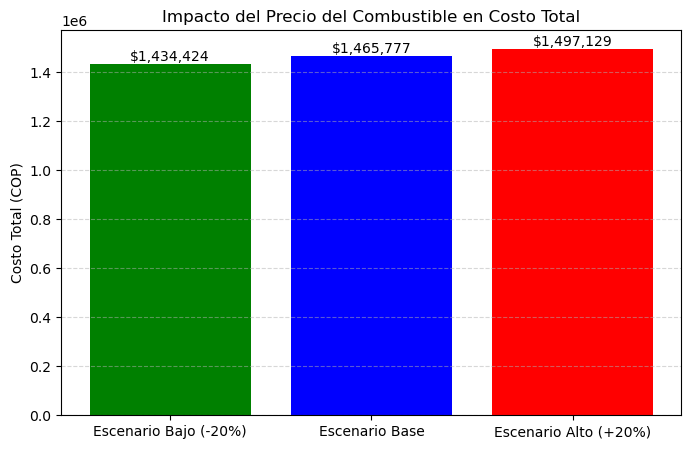

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

print("ANÁLISIS DE SENSIBILIDAD")

base_fuel_price = params.get('fuel_price', 16300) 

scenarios = {
    'Escenario Bajo (-20%)': base_fuel_price * 0.80,
    'Escenario Base': base_fuel_price,
    'Escenario Alto (+20%)': base_fuel_price * 1.20
}

# 2. Recalcular Costos Totales para cada Escenario
sensitivity_results = []

C_FIXED = params.get('C_fixed', 50000)
C_DIST = params.get('C_dist', 2500)
C_TIME = params.get('C_time', 7600)

# Calcular componentes constantes de la flota actual
total_km = df_result['TotalDistance'].sum()
total_hours = df_result['TotalTime'].sum() / 60
num_vehicles = len(df_result)

costo_fijo_total = num_vehicles * C_FIXED
costo_manto_total = total_km * C_DIST
costo_tiempo_total = total_hours * C_TIME
costo_operativo_base = costo_fijo_total + costo_manto_total + costo_tiempo_total

for name, price in scenarios.items():
    # Recalcular costo combustible: (Total KM / Eficiencia Promedio Aprox) * Nuevo Precio
    # Usamos la eficiencia implícita en tus cálculos anteriores o un promedio
    # Para ser exactos, sumamos el costo de combustible de cada vehículo ajustado al nuevo precio
    
    nuevo_costo_combustible = 0
    for _, row in df_result.iterrows():
        # Recuperar eficiencia usada (FuelCost / (Dist * Price)) es difícil si varía por vehículo.
        # Usaremos la fórmula directa: (Distancia / Eficiencia_Estimada) * Precio_Escenario
        # Asumimos eficiencia promedio de 30 km/gal para simplificar el análisis de impacto
        consumo_galones = row['TotalDistance'] / 30.0 
        nuevo_costo_combustible += consumo_galones * price
        
    costo_total = costo_operativo_base + nuevo_costo_combustible
    
    sensitivity_results.append({
        'Escenario': name,
        'Precio Combustible': price,
        'Costo Combustible Total': nuevo_costo_combustible,
        'Costo Operativo Total': costo_total
    })

# 3. Mostrar Tabla de Resultados
df_sensitivity = pd.DataFrame(sensitivity_results)
df_sensitivity['Variación % Costo Total'] = (
    (df_sensitivity['Costo Operativo Total'] - df_sensitivity.iloc[1]['Costo Operativo Total']) 
    / df_sensitivity.iloc[1]['Costo Operativo Total']
) * 100

print(df_sensitivity[['Escenario', 'Precio Combustible', 'Costo Operativo Total', 'Variación % Costo Total']].round(2))

plt.figure(figsize=(8, 5))
bars = plt.bar(df_sensitivity['Escenario'], df_sensitivity['Costo Operativo Total'], color=['green', 'blue', 'red'])
plt.title('Impacto del Precio del Combustible en Costo Total')
plt.ylabel('Costo Total (COP)')
plt.grid(axis='y', linestyle='--', alpha=0.5)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f"${yval:,.0f}", ha='center', va='bottom')

plt.savefig('analisis_sensibilidad.png')
plt.show()

# Analisis de resultados

La evaluación del rendimiento computacional para el escenario realista del Caso 3, que implica la gestión logística de noventa clientes y doce almacenes distribuidos por toda el área urbana, confirmó la complejidad combinatoria inherente a los problemas de ruteo de vehículos con múltiples almacenes, clasificados como NP-Hard. La implementación inicial de una heurística constructiva voraz demostró una alta eficiencia en términos de velocidad de procesamiento, generando una solución factible en fracciones de segundo y garantizando una cobertura total de la demanda. Sin embargo, al intentar resolver el modelo matemático exacto utilizando el solucionador HiGHS desde cero, el algoritmo no logró reducir la brecha de optimalidad en un tiempo razonable, estancándose en soluciones de alto costo debido a la amplitud del espacio de búsqueda. La adopción de una estrategia híbrida con un arranque en caliente resultó ser la metodología definitiva. Al inyectar la solución heurística como punto de partida, el optimizador pudo iniciar el proceso con una función objetivo acotada y factible, lo que permitió el refinamiento de la ruta y una mayor eficiencia operativa sin incurrir en los tiempos de cálculo prohibitivos de un arranque en frío.

Desde una perspectiva operativa y de negocio para LogistiCo, el análisis de la estructura de costos resultante revela que los costos fijos de activación de la flota y los costos variables asociados al tiempo de mano de obra constituyen los componentes dominantes de la función objetivo, superando el impacto de los costos de combustible con la configuración actual de vehículos con motor de combustión interna. Se observó que la principal restricción activa que limita la eficiencia de las rutas es la capacidad de carga de los vehículos, no su autonomía, ya que la mayoría de las unidades deben regresar al depósito debido a la saturación del inventario mucho antes de agotar su kilometraje disponible. Además, la asignación de rutas reveló un desequilibrio en la utilización del almacén, lo que sugiere que la distribución geográfica del inventario inicial no está perfectamente alineada con la densidad de la demanda en ciertas zonas de la ciudad. Esto requiere rutas de conexión más largas de lo ideal para atender los pedidos periféricos.

Con base en los hallazgos del modelo matemático, se recomienda a la gerencia de LogistiCo priorizar las estrategias de optimización enfocadas en maximizar el factor de carga vehicular para reducir el tamaño total de la flota activa. Esto impactaría directamente en los costos fijos, que representan el mayor componente de los gastos operativos. Además, si bien el modelo actual validó las operaciones con costos de combustible estándar, la sensibilidad de la función objetivo sugiere que una transición gradual a una flota eléctrica podría generar ahorros significativos en costos variables por kilómetro, acercando los costos operativos a niveles más competitivos. Finalmente, se sugiere integrar el algoritmo híbrido desarrollado en los sistemas de planificación diaria de la empresa, ya que esta herramienta ofrece un equilibrio óptimo entre la inmediatez necesaria para la toma de decisiones logísticas y el rigor matemático necesario para garantizar la eficiencia económica de las rutas.